# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_pickle('base_nfp.pkl')
df = df[df['Data Emissão'] >= '2020-01-01']
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado
64600,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,2020-01-01,35.90,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Alimentos
64601,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,2020-01-01,21.77,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Farmácia
64602,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,2020-01-01,80.95,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [29]:
# Garantindo que a coluna 'Data Emissão' está no formato correto (datetime)
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Criando as variáveis temporais
df['Dia da Semana'] = df['Data Emissão'].dt.day_name()  # Nome do dia da semana
df['Fim de Semana'] = df['Data Emissão'].dt.weekday.isin([5, 6]).astype(int)  # 1 para Sábado e Domingo, 0 para outros dias
df['Dia do Mês'] = df['Data Emissão'].dt.day  # Dia do mês
df['Mês'] = df['Data Emissão'].dt.month  # Mês
df['Trimestre'] = df['Data Emissão'].dt.quarter  # Trimestre
df['Ano'] = df['Data Emissão'].dt.year  # Ano

# Exibindo as primeiras linhas para verificar as novas colunas
df[['Data Emissão', 'Dia da Semana', 'Fim de Semana', 'Dia do Mês', 'Mês', 'Trimestre', 'Ano']].head()


,Data Emissão,Dia da Semana,Fim de Semana,Dia do Mês,Mês,Trimestre,Ano
64598,2020-01-01,Wednesday,0,1,1,1,2020
64599,2020-01-01,Wednesday,0,1,1,1,2020
64600,2020-01-01,Wednesday,0,1,1,1,2020
64601,2020-01-01,Wednesday,0,1,1,1,2020
64602,2020-01-01,Wednesday,0,1,1,1,2020


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [30]:
# Função para calcular WOE e IV para uma variável categórica
def calculate_woe_iv(dataframe, variable, target):
    # Agrupamento por categoria com a contagem de eventos e não eventos
    groups = dataframe.groupby(variable)[target].agg(['sum', 'count'])
    groups.columns = ['eventos', 'total']
    groups['nao_eventos'] = groups['total'] - groups['eventos']

    # Proporção de eventos e não eventos
    groups['distr_eventos'] = groups['eventos'] / groups['eventos'].sum()
    groups['distr_nao_eventos'] = groups['nao_eventos'] / groups['nao_eventos'].sum()

    # Calculando WOE e IV
    groups['WOE'] = np.log(groups['distr_eventos'] / groups['distr_nao_eventos'])
    groups['IV'] = (groups['distr_eventos'] - groups['distr_nao_eventos']) * groups['WOE']

    return groups['IV'].sum()

# Variáveis temporais
temporal_vars = ['Dia da Semana', 'Fim de Semana', 'Dia do Mês', 'Mês', 'Trimestre', 'Ano']

# Cálculo do IV para cada variável temporal
iv_values = {var: calculate_woe_iv(df, var, 'flag_credito') for var in temporal_vars}
iv_values


{'Dia da Semana': 0.005877637687464065,
 'Fim de Semana': 0.004598647330024025,
 'Dia do Mês': 0.015128065365420908,
 'Mês': 0.009097926154720515,
 'Trimestre': 0.003553872139145808,
 'Ano': 0.003195387533350801}

## Conclusões

Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- As variáveis que apresentaram maior poder de discriminação foram: Dia do Mês e Mês.
- As variáveis que apresentaram menor poder de discriminação foram: Trimestre e Ano.

Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?
- Se uma variável contínua é dividida em muitas categorias pequenas, isso pode levar à sobre-ajuste (overfitting) e a categorias com poucos dados, reduzindo a estabilidade e a confiabilidade dos cálculos de WOE e IV.
- Por outro lado, se a variável é categorizada em poucas e amplas categorias, isso pode levar a uma perda de informação valiosa, tornando a variável menos discriminatória e potencialmente reduzindo o IV.


## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

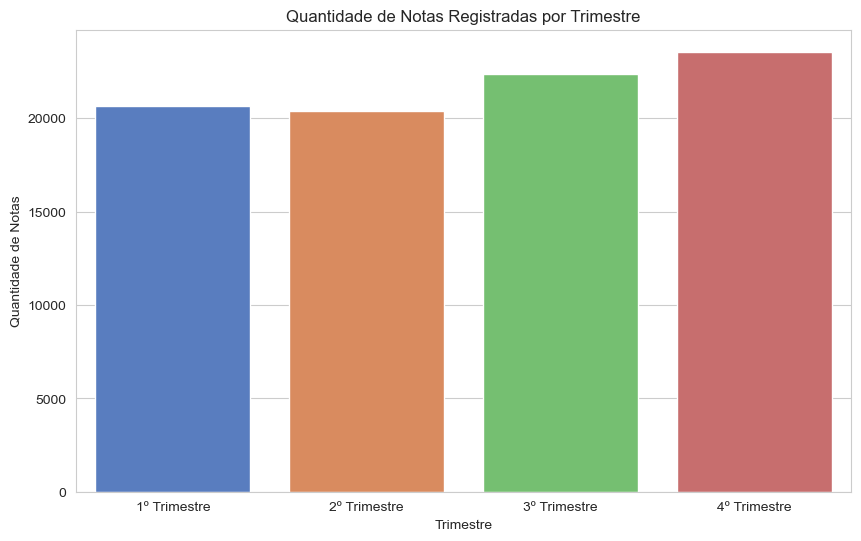

In [31]:
# Agrupando dados por trimestre e contando o número de notas
notas_por_trimestre = df.groupby('Trimestre').size()

# Criando o gráfico para a quantidade de notas por trimestre
plt.figure(figsize=(10, 6))
sns.barplot(x=notas_por_trimestre.index, y=notas_por_trimestre.values, palette="muted")
plt.title('Quantidade de Notas Registradas por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(range(0, 4), ['1º Trimestre', '2º Trimestre', '3º Trimestre', '4º Trimestre'])
plt.show()

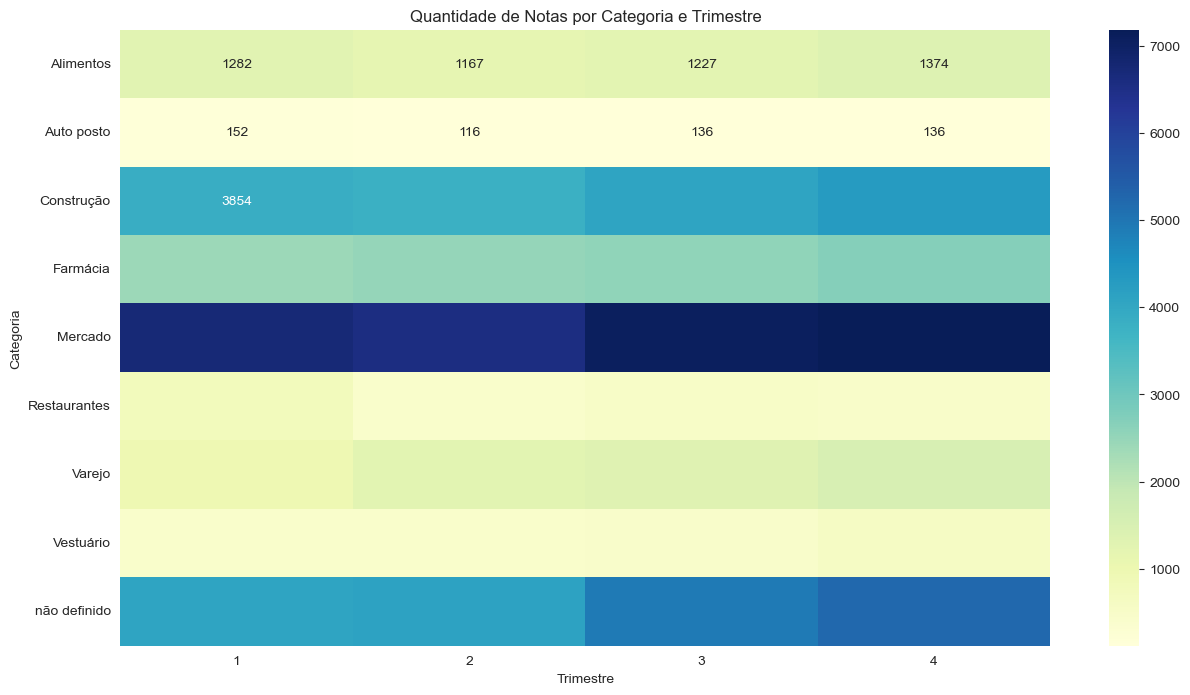

In [35]:
# Agrupando dados por categoria e trimestre
notas_por_categoria_trimestre = df.groupby(['categoria', 'Trimestre']).size().unstack(fill_value=0)

# Criando o gráfico para a quantidade de notas por categoria e trimestre
plt.figure(figsize=(15, 8))
sns.heatmap(notas_por_categoria_trimestre, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title('Quantidade de Notas por Categoria e Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Categoria')
plt.yticks(rotation=0)
plt.show()

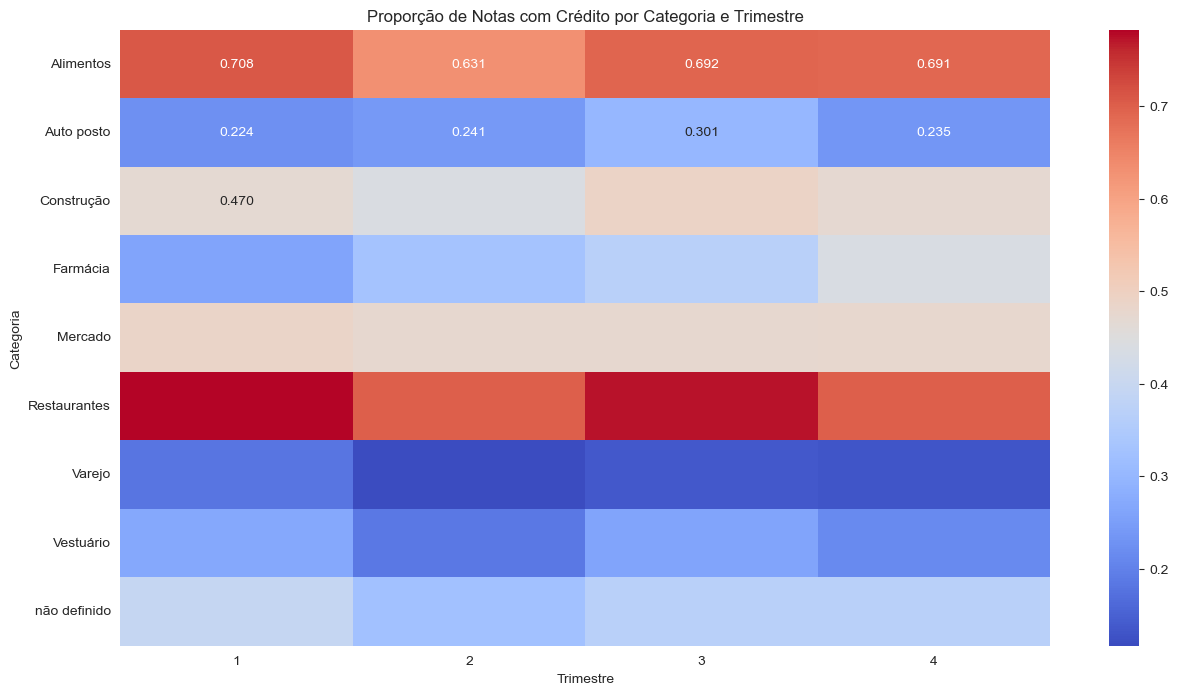

In [33]:
# Calculando a proporção de notas com crédito (flag_credito = 1) por categoria e trimestre
prop_credito_categoria_trimestre = df.groupby(['categoria', 'Trimestre'])['flag_credito'].mean().unstack(fill_value=0)

# Criando o gráfico para a proporção de notas com crédito por categoria e trimestre
plt.figure(figsize=(15, 8))
sns.heatmap(prop_credito_categoria_trimestre, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title('Proporção de Notas com Crédito por Categoria e Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Categoria')
plt.yticks(rotation=0)
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [37]:
def calcula_woe_iv(data, feature, target, small_value=0.0001):
    # Calculando a distribuição de frequência para a variável e o alvo
    dist = data.groupby([feature])[target].agg(['count', 'sum'])
    dist.columns = ['Total', 'Bad']
    dist['Good'] = dist['Total'] - dist['Bad']

    # Adicionando uma pequena constante para evitar divisão por zero
    dist['Bad'] = dist['Bad'].apply(lambda x: x if x > 0 else small_value)
    dist['Good'] = dist['Good'].apply(lambda x: x if x > 0 else small_value)

    # Calculando o total de bons e maus
    total_good = sum(dist['Good'])
    total_bad = sum(dist['Bad'])

    # Calculando a proporção e o WOE
    dist['Distr_Good'] = dist['Good'] / total_good
    dist['Distr_Bad'] = dist['Bad'] / total_bad
    dist['WOE'] = np.log(dist['Distr_Good'] / dist['Distr_Bad'])

    # Calculando o IV
    dist['IV'] = (dist['Distr_Good'] - dist['Distr_Bad']) * dist['WOE']
    IV = sum(dist['IV'])

    return dist[['WOE']], IV

def calcula_woe_iv_por_categoria(data, feature, target, small_value=0.0001):
    # Calculando a distribuição de frequência para a variável e o alvo
    dist = data.groupby([feature])[target].agg(['count', 'sum'])
    dist.columns = ['Total', 'Bad']
    dist['Good'] = dist['Total'] - dist['Bad']

    # Adicionando uma pequena constante para evitar divisão por zero
    dist['Bad'] = dist['Bad'].apply(lambda x: x if x > 0 else small_value)
    dist['Good'] = dist['Good'].apply(lambda x: x if x > 0 else small_value)

    # Calculando o total de bons e maus
    total_good = sum(dist['Good'])
    total_bad = sum(dist['Bad'])

    # Calculando a proporção e o WOE
    dist['Distr_Good'] = dist['Good'] / total_good
    dist['Distr_Bad'] = dist['Bad'] / total_bad
    dist['WOE'] = np.log(dist['Distr_Good'] / dist['Distr_Bad'])

    # Calculando o IV por categoria
    dist['IV'] = (dist['Distr_Good'] - dist['Distr_Bad']) * dist['WOE']

    # Calculando o IV total
    IV_total = sum(dist['IV'])

    return dist[['WOE', 'IV']], IV_total

def calculate_woe_iv_temporal(data, feature, target, time_col, small_value=0.001):
    # Agrupando os dados por trimestre e categoria
    grouped = data.groupby([time_col, feature])

    # Calculando a distribuição de frequência para cada grupo
    dist = grouped[target].agg(['count', 'sum'])
    dist.columns = ['Total', 'Bad']
    dist['Good'] = dist['Total'] - dist['Bad']

    # Adicionando uma pequena constante para evitar divisão por zero
    dist['Bad'] = dist['Bad'].apply(lambda x: x if x > 0 else small_value)
    dist['Good'] = dist['Good'].apply(lambda x: x if x > 0 else small_value)

    # Calculando o total de bons e maus por trimestre
    total = dist.groupby(level=0).sum()
    total_good = total['Good']
    total_bad = total['Bad']

    # Calculando a proporção, WOE e IV para cada grupo
    dist['Distr_Good'] = dist['Good'] / dist['Good'].groupby(level=0).transform('sum')
    dist['Distr_Bad'] = dist['Bad'] / dist['Bad'].groupby(level=0).transform('sum')
    dist['WOE'] = np.log(dist['Distr_Good'] / dist['Distr_Bad'])
    dist['IV'] = (dist['Distr_Good'] - dist['Distr_Bad']) * dist['WOE']

    # Calculando o IV total por trimestre
    IV_total = dist.groupby(level=0)['IV'].sum()

    return dist.reset_index()[[time_col, feature, 'WOE', 'IV']], IV_total


result, IV_total = calculate_woe_iv_temporal(df, 'categoria', 'flag_credito', 'Trimestre')

print(f'IV total: {IV_total}')
print(f'\nWOE e IV por categoria:\n{result}')




IV total: Trimestre
1    0.320254
2    0.293088
3    0.280025
4    0.278544
Name: IV, dtype: float64

WOE e IV por categoria:
    Trimestre     categoria       WOE        IV
0           1     Alimentos -1.117843  0.074690
1           1    Auto posto  1.013469  0.006613
2           1    Construção -0.110315  0.002281
3           1      Farmácia  0.803010  0.069025
4           1       Mercado -0.175839  0.010140
5           1  Restaurantes -1.511111  0.075970
6           1        Varejo  1.277091  0.062113
7           1     Vestuário  0.773606  0.011357
8           1  não definido  0.203438  0.008064
9           2     Alimentos -0.925942  0.049996
10          2    Auto posto  0.754312  0.002890
11          2    Construção -0.155371  0.004563
12          2      Farmácia  0.327109  0.012564
13          2       Mercado -0.283624  0.026396
14          2  Restaurantes -1.247076  0.032284
15          2        Varejo  1.631265  0.120562
16          2     Vestuário  1.089057  0.020607
17        

## Conclusão

Com base nos dados fornecidos, que incluem o Weight of Evidence (WOE) e o Information Value (IV) para cada categoria ao longo dos trimestres, podemos chegar às seguintes conclusões:

### Quais Categorias Têm Maior Proporção de Notas com Retornos Maiores que Zero?

Para identificar as categorias com maior proporção de notas com retornos maiores que zero, devemos observar as que têm WOE positivo. Um WOE positivo indica que a categoria está mais associada ao evento (neste caso, notas com retorno maior que zero). As categorias com os maiores WOEs positivos em cada trimestre provavelmente são aquelas com maior proporção de notas com retorno.

Analisando os dados, as categorias com WOEs consistentemente positivos em todos os trimestres são:

- **Auto posto**
- **Varejo**
- **Vestuário** (trimestres 3 e 4)
- **Farmácia** (trimestres 1, 2 e 3)
- **Não definido**

### Estabilidade dessas Diferenças no Tempo

Para avaliar se essas diferenças são estáveis no tempo, precisamos observar se o WOE de cada categoria se mantém relativamente constante ao longo dos trimestres. Uma categoria é considerada estável se o seu WOE não apresenta grandes variações ao longo dos períodos analisados.

- **Auto posto** e **Varejo** parecem ter WOEs positivos consistentes ao longo dos quatro trimestres, sugerindo uma estabilidade na associação dessas categorias com notas de retorno maior que zero.
- **Vestuário** e **Farmácia** apresentam alguma variação. Vestuário torna-se mais associado a retornos maiores que zero nos últimos dois trimestres, enquanto Farmácia tem uma associação positiva nos três primeiros trimestres, mas não no último.
- **Não definido** também mostra alguma consistência, mas com WOEs positivos menores em comparação com as outras categorias.

Categorias como **Auto posto** e **Varejo** parecem ter uma maior e mais estável proporção de notas com retornos maiores que zero ao longo do tempo. Categorias como **Vestuário** e **Farmácia** mostram uma associação variável com o evento ao longo dos trimestres.